<a href="https://www.kaggle.com/code/anhnguyen811/our-humble-top-7-of-the-competition?scriptVersionId=125998490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgbm

In [2]:
df = pd.read_csv("../input/train-folds-5/train_folds.csv")
df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# Training the models on the prediction set from the base level
xgb_df = pd.read_csv('../input/1st-layer-model-stacking/xgb_train_pred (1).csv')
xgb_df.columns = ["id", "xgbpred"]

lgb_df = pd.read_csv('../input/1st-layer-model-stacking/lgb_train_pred (1).csv')
lgb_df.columns = ["id", "lgbpred"]

gbr_df = pd.read_csv('../input/1st-layer-model-stacking/gbr_train_pred (1).csv')
gbr_df.columns= ["id", "gbrpred"]

rf_df = pd.read_csv('../input/1st-layer-model-stacking/rf_train_pred (2).csv')
rf_df.columns = ['id', 'rfpred']

lass_df = pd.read_csv('../input/ridge-and-lasso-preds-30-days-of-ml/lass_train_pred.csv')
lass_df.columns = ['id','lasspred']

ridge_df = pd.read_csv('../input/ridge-and-lasso-preds-30-days-of-ml/ridge_train_pred.csv')
ridge_df.columns = ['id','ridgepred']

xgb_df_test = pd.read_csv('../input/1st-layer-model-stacking/xgb_test_pred (1).csv')
xgb_df_test.columns = ["id", "xgbpred"]

rf_df_test = pd.read_csv('../input/1st-layer-model-stacking/rf_test_pred (2).csv')
rf_df_test.columns = ['id', 'rfpred']

lgb_df_test = pd.read_csv('../input/1st-layer-model-stacking/lgb_test_pred (1).csv')
lgb_df_test.columns = ["id", "lgbpred"]

gbr_df_test = pd.read_csv('../input/1st-layer-model-stacking/gbr_test_pred (2).csv')
gbr_df_test.columns = ["id", "gbrpred"]

lass_df_test = pd.read_csv('../input/ridge-and-lasso-preds-30-days-of-ml/lass_test_pred.csv')
lass_df_test.columns = ['id','lasspred']

ridge_df_test = pd.read_csv('../input/ridge-and-lasso-preds-30-days-of-ml/ridge_train_pred.csv')
ridge_df_test.columns = ['id','ridgepred']
# *** Merging dataframes
df = df.merge(xgb_df, on="id", how="left")
df = df.merge(lgb_df, on="id", how="left")
df = df.merge(rf_df, on="id", how="left")
df = df.merge(gbr_df,on="id", how="left" )
df = df.merge(lass_df,on="id", how="left")
df = df.merge (ridge_df,on="id", how="left" )
df_test = df_test.merge(xgb_df_test, on='id',how="left")
df_test = df_test.merge(lgb_df_test, on='id', how="left")
df_test = df_test.merge(rf_df_test, on='id', how="left")
df_test = df_test.merge(gbr_df_test, on='id', how="left")
df_test = df_test.merge(lass_df_test, on='id', how="left")
df_test = df_test.merge(ridge_df_test, on='id', how="left")


In [3]:
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont12,cont13,target,kfold,xgbpred,lgbpred,rfpred,gbrpred,lasspred,ridgepred
0,1,B,B,B,C,B,B,A,E,C,...,0.322401,0.869850,8.113634,0,8.474278,8.372187,8.325544,8.282045,8.183844,8.183844
1,2,B,B,A,A,B,D,A,F,A,...,0.261975,0.465083,8.481233,2,8.442590,8.446587,8.304636,8.317891,8.479644,8.479644
2,3,A,A,A,C,B,D,A,D,A,...,0.541474,0.763846,8.364351,4,8.216881,8.188557,8.031787,8.114722,8.180161,8.180161
3,4,B,B,A,C,B,D,A,E,C,...,0.540150,0.280682,8.049253,3,8.350539,8.324131,8.280681,8.300207,8.272755,8.272755
4,6,A,A,A,C,B,D,A,E,A,...,0.625849,0.250823,7.972260,1,8.263093,8.149964,8.295357,8.148920,8.318773,8.318773


In [4]:
df_test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont10,cont11,cont12,cont13,xgbpred,lgbpred,rfpred,gbrpred,lasspred,ridgepred
0,0,B,B,B,C,B,B,A,E,E,...,0.244476,0.087914,0.301831,0.845702,8.083041,8.083041,8.083041,8.083041,8.083041,NaN
1,5,A,B,A,C,B,C,A,E,C,...,0.549568,0.905097,0.850684,0.693940,8.395948,8.395948,8.395948,8.395948,8.395948,NaN
2,15,B,A,A,A,B,B,A,E,D,...,0.491667,0.384315,0.376689,0.508099,8.402651,8.402651,8.402651,8.402651,8.402651,NaN
3,16,B,B,A,C,B,D,A,E,A,...,0.988340,0.411828,0.393585,0.461372,8.492390,8.492390,8.492390,8.492390,8.492390,NaN
4,17,B,B,A,C,B,C,A,E,C,...,0.648932,0.385935,0.370401,0.900412,8.136203,8.136203,8.136203,8.136203,8.136203,NaN


In [5]:
# Return any column with missing values. No columns with missing values found
df.columns[df.isnull().any()]

Index([], dtype='object')

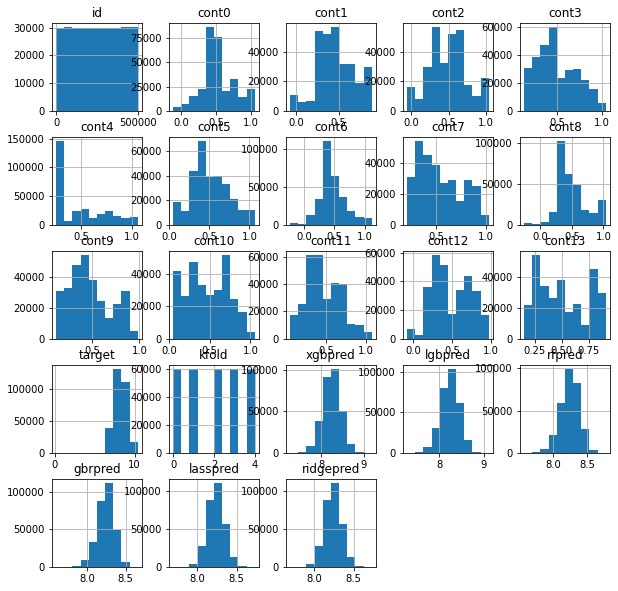

In [6]:
#Histograms for each var
df_hist = df.hist(bins=10,figsize=(10,10))

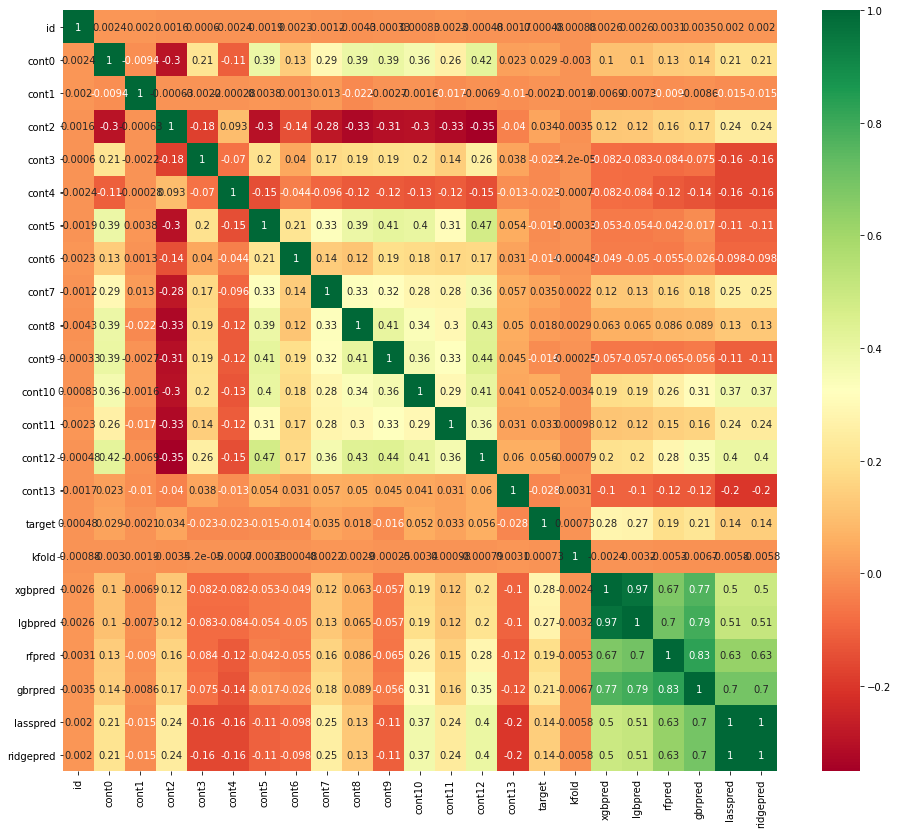

In [7]:
#creating a heatmap to show correlation
fig,axes = plt.subplots(1,1,figsize=(16,14))
sns.heatmap(df.corr(),annot=True, cmap="RdYlGn")
plt.show()

In [8]:
# Select categorical vars only

df_cat = df.select_dtypes(include = 'object').copy()
# counts of each var value
df_cat.nunique()

cat0     2
cat1     2
cat2     2
cat3     4
cat4     4
cat5     4
cat6     8
cat7     8
cat8     7
cat9    15
dtype: int64

In [9]:
# Calculating the numbers of each unique values for each categorical var using lambda expression
df_cat.apply(lambda x:x.value_counts()).T.stack()


cat0  A    193130.0
      B    106870.0
cat1  A    154824.0
      B    145176.0
cat2  A    253886.0
      B     46114.0
cat3  A     31726.0
      B       590.0
      C    263356.0
      D      4328.0
cat4  A      2978.0
      B    294737.0
      C      1772.0
      D       513.0
cat5  A      4275.0
      B    149340.0
      C     20248.0
      D    126137.0
cat6  A    290511.0
      B      8018.0
      C       928.0
      D       292.0
      E        45.0
      G        14.0
      H        56.0
      I       136.0
cat7  A        31.0
      B      8297.0
      C        36.0
      D     12144.0
      E    276040.0
      F       562.0
      G      2870.0
      I        20.0
cat8  A     76585.0
      B       187.0
      C    111103.0
      D      5187.0
      E     79844.0
      F       966.0
      G     26128.0
cat9  A     11029.0
      B     14477.0
      C      1603.0
      D      1088.0
      E      1039.0
      F     71249.0
      G     28253.0
      H     19925.0
      I     59218.0


In [10]:
kept_features = ['xgbpred', 'lgbpred','rfpred','gbrpred','lasspred','ridgepred']
df_test = df_test[kept_features]

In [11]:
xgb_params ={'random_state': 1, 
        'booster': 'gbtree',
        'n_estimators': 10000,
        'learning_rate': 0.03628302216953097,
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'subsample': 0.7875490025178415,
        'colsample_bytree': 0.11807135201147481,
        'max_depth': 3
             }

In [12]:
df = pd.read_csv("../input/train-folds-5/train_folds.csv")
df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")
kept_features = [useful_cols for useful_cols in df.columns if useful_cols not in ('id','kfold','target')]
object_cols = [col for col in kept_features if 'cat' in col]
# Creating a var for numerical columns for feature engineering
numerical_cols = [col for col in kept_features if 'cont' in col]
df_test=df_test[kept_features]

In [13]:
#Building an XGBoost model for stacking

xgb_final_test_predictions = []
xgb_final_valid_predictions = {}
scores = []
# creating a for loop to loop over fold, reserving -1 fold for training data
for fold in range(5):
    # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()
    #creating a list of validation set's indices
    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]
    # ordinal-encode categorical columns
    OE = preprocessing.OrdinalEncoder()
    
    # always fit_transform on the training data
    x_train[object_cols] = OE.fit_transform(x_train[object_cols])
    
    #transform on the validation and test sets
    x_valid[object_cols] = OE.transform(x_valid[object_cols])
    x_test[object_cols] = OE.transform(x_test[object_cols])
    
    # Feature engineering for numerical var : standardisation
    
    scaler = preprocessing.StandardScaler()
    # standardise training data, using .fit_transform()
    x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
    #standardise validation and test data using .transform()
    x_valid[numerical_cols] = scaler.transform(x_valid[numerical_cols])
    x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])
    
    
    #using XGBRegressor 
    xgb_model = XGBRegressor(**xgb_params,
                              n_jobs =4
                              )
    xgb_model.fit(x_train, y_train, early_stopping_rounds=300, eval_set=[(x_valid, y_valid)], verbose=1000)
    xgb_preds_valid = xgb_model.predict(x_valid)
    xgb_test_preds = xgb_model.predict(x_test)
    xgb_final_test_predictions.append(xgb_test_preds)
    xgb_final_valid_predictions.update(dict(zip(valid_id, xgb_preds_valid)))
    RMSE = mean_squared_error(y_valid, xgb_preds_valid, squared=False)
    print(fold, RMSE)
    scores.append(RMSE)
# Printing out of the loop 
print(np.mean(scores), np.std(scores))
xgb_final_valid_predictions = pd.DataFrame.from_dict(xgb_final_valid_predictions, orient="index").reset_index()
xgb_final_valid_predictions.columns = ["id", "xgbpred_1"]
xgb_final_valid_predictions.to_csv("xgb_train_pred_1.csv", index=False)

submission.target = np.mean(np.column_stack(xgb_final_test_predictions), axis=1)
submission.columns = ["id", "xgbpred_1"]
submission.to_csv("xgb_test_pred_1.csv", index=False)

[0]	validation_0-rmse:7.50023
[1000]	validation_0-rmse:0.72306
[2000]	validation_0-rmse:0.71901
[3000]	validation_0-rmse:0.71737
[4000]	validation_0-rmse:0.71650
[5000]	validation_0-rmse:0.71605
[6000]	validation_0-rmse:0.71585
[7000]	validation_0-rmse:0.71572
[8000]	validation_0-rmse:0.71567
[8511]	validation_0-rmse:0.71566
0 0.7156455791198685
[0]	validation_0-rmse:7.49700
[1000]	validation_0-rmse:0.72274
[2000]	validation_0-rmse:0.71864
[3000]	validation_0-rmse:0.71698
[4000]	validation_0-rmse:0.71626
[5000]	validation_0-rmse:0.71593
[6000]	validation_0-rmse:0.71578
[7000]	validation_0-rmse:0.71574
[7126]	validation_0-rmse:0.71574
1 0.7157222164409861
[0]	validation_0-rmse:7.49484
[1000]	validation_0-rmse:0.72454
[2000]	validation_0-rmse:0.72044
[3000]	validation_0-rmse:0.71893
[4000]	validation_0-rmse:0.71814
[5000]	validation_0-rmse:0.71776
[6000]	validation_0-rmse:0.71761
[7000]	validation_0-rmse:0.71754
[7141]	validation_0-rmse:0.71753
2 0.7175291411246139
[0]	validation_0-rmse:

In [14]:
lgb_params = { "objective": "regression",
             "metric": "rmse",
             "boosting_type": "gbdt",
             "n_estimators": 10000,
             "early_stopping_round": 300,
   'colsample_tree': 0.9966937316093348,
 'learning_rate': 0.23205382167938451,
 'max_depth': 2,
 'reg_alpha': 21.312138571025006,
 'reg_lambda': 4.4379149320083925e-08,
 'subsample': 0.21475469764965427}

In [15]:
#Building a LightGBM
import lightgbm as lgbm

lgb_final_test_predictions = []
lgb_final_valid_predictions = {}
scores = []
# creating a for loop to loop over fold, reserving -1 fold for training data
for fold in range(5):
    # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()

    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]
     # ordinal-encode categorical columns
    OE = preprocessing.OrdinalEncoder()
    
    # always fit_transform on the training data
    x_train[object_cols] = OE.fit_transform(x_train[object_cols])
    
    #transform on the validation and test sets
    x_valid[object_cols] = OE.transform(x_valid[object_cols])
    x_test[object_cols] = OE.transform(x_test[object_cols])
    
    # Feature engineering for numerical var : standardisation
    
    scaler = preprocessing.StandardScaler()
    # standardise training data, using .fit_transform()
    x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
    #standardise validation and test data using .transform()
    x_valid[numerical_cols] = scaler.transform(x_valid[numerical_cols])
    x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])
    lgb_train = lgbm.Dataset(x_train, y_train)
    lgb_valid = lgbm.Dataset(x_valid, y_valid, reference = lgb_train)
   
    #using LGBM  
    lgb_model = lgbm.train(lgb_params, lgb_train, 
                                 valid_sets = [lgb_valid],
                                  verbose_eval = 1000
                              )
  
    lgb_preds_valid = lgb_model.predict(x_valid)
    lgb_test_preds = lgb_model.predict(x_test)
    lgb_final_test_predictions.append(lgb_test_preds)
    lgb_final_valid_predictions.update(dict(zip(valid_id, lgb_preds_valid)))
    print(mean_squared_error(y_valid, lgb_preds_valid, squared=False))
    RMSE = mean_squared_error(y_valid, lgb_preds_valid, squared=False)
    print(fold,RMSE)
    scores.append(RMSE)

print (np.mean(scores),np.std(scores))
lgb_final_valid_predictions = pd.DataFrame.from_dict(lgb_final_valid_predictions, orient="index").reset_index()
lgb_final_valid_predictions.columns = ["id", "lgbpred_1"]
lgb_final_valid_predictions.to_csv("lgb_train_pred_1.csv", index=False)

submission.target = np.mean(np.column_stack(lgb_final_test_predictions), axis=1)
submission.columns = ["id", "lgbpred_1"]
submission.to_csv("lgb_test_pred_1.csv", index=False)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Info] Start training from score 8.241467
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.718661
[2000]	valid_0's rmse: 0.717827
Early stopping, best iteration is:
[2044]	valid_0's rmse: 0.717801
0.7178014728569714
0 0.7178014728569714


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Info] Start training from score 8.242281
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.718033
[2000]	valid_0's rmse: 0.717428
Early stopping, best iteration is:
[1853]	valid_0's rmse: 0.717409
0.7174090806749158
1 0.7174090806749158


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Info] Start training from score 8.242864
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.720369
[2000]	valid_0's rmse: 0.719839
Early stopping, best iteration is:
[1845]	valid_0's rmse: 0.719822
0.7198222952065686
2 0.7198222952065686


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Info] Start training from score 8.242307
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.720137
Early stopping, best iteration is:
[1628]	valid_0's rmse: 0.719675
0.7196754581834746
3 0.7196754581834746


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 24
[LightGBM] [Warning] Unknown parameter: colsample_tree
[LightGBM] [Info] Start training from score 8.240972
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.718545
[2000]	valid_0's rmse: 0.718033
Early stopping, best iteration is:
[2195]	valid_0's rmse: 0.717972
0.7179717984149597
4 0.7179717984149597
0.7185360210673781 0.0010080397835170237


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [16]:
rf_params = {'min_samples_split': 2,
             'min_samples_leaf': 4, 
             'max_features': 'sqrt', 
             'max_depth': None, 
             'bootstrap': False}

In [17]:
# Building a random forest model

rf_final_test_predictions = []
rf_final_valid_predictions = {}
scores =[]

for fold in range(5):
    # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()
    #creating a list of validation set's indices
    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]
     # ordinal-encode categorical columns
    OE = preprocessing.OrdinalEncoder()
    
    # always fit_transform on the training data
    x_train[object_cols] = OE.fit_transform(x_train[object_cols])
    
    #transform on the validation and test sets
    x_valid[object_cols] = OE.transform(x_valid[object_cols])
    x_test[object_cols] = OE.transform(x_test[object_cols])
    
    # Feature engineering for numerical var : standardisation
    
    scaler = preprocessing.StandardScaler()
    # standardise training data, using .fit_transform()
    x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
    #standardise validation and test data using .transform()
    x_valid[numerical_cols] = scaler.transform(x_valid[numerical_cols])
    x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])
    #using RandomForestRegressor
    rf_model = RandomForestRegressor(**rf_params, random_state=1)
    rf_model.fit(x_train, y_train)
    rf_preds_valid = rf_model.predict(x_valid)
    rf_test_preds = rf_model.predict(x_test)
    rf_final_test_predictions.append(rf_test_preds)
    # use function zip() to create a zip object and store it in a dictionary
    rf_final_valid_predictions.update(dict(zip(valid_id, rf_preds_valid)))
    RMSE = mean_squared_error(y_valid, rf_preds_valid, squared=False)
    print(fold,RMSE)
    scores.append(RMSE)
print (np.mean(scores),np.std(scores))
rf_final_valid_predictions = pd.DataFrame.from_dict(rf_final_valid_predictions, orient='index').reset_index()
rf_final_valid_predictions.columns = ['id', 'rfpred_1']
rf_final_valid_predictions.to_csv('rf_train_pred_1.csv', index=False)
    
submission.target = np.mean(np.column_stack(rf_final_test_predictions), axis=1)
submission.columns = ['id', 'rfpred_1']
submission.to_csv ("rf_test_pred_1.csv",index=False)

0 0.7324349110006073
1 0.7324420616140705
2 0.7339217178765474
3 0.7334583986951988
4 0.733551362423201
0.733161690321925 0.0006105072887578195


In [18]:
gbr_params= {'learning_rate': 0.021030330096493244, 
 'max_depth': 4, 'n_estimators': 968, 
 'subsample': 0.579236968137102}

In [19]:
#Building a Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor

gbr_final_test_predictions = []
gbr_final_valid_predictions = {}
scores = []
# creating a for loop to loop over fold, reserving -1 fold for training data
for fold in range(5):
    # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()

    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]
     # ordinal-encode categorical columns
    OE = preprocessing.OrdinalEncoder()
    
    # always fit_transform on the training data
    x_train[object_cols] = OE.fit_transform(x_train[object_cols])
    
    #transform on the validation and test sets
    x_valid[object_cols] = OE.transform(x_valid[object_cols])
    x_test[object_cols] = OE.transform(x_test[object_cols])
    
    # Feature engineering for numerical var : standardisation
    
    scaler = preprocessing.StandardScaler()
    # standardise training data, using .fit_transform()
    x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
    #standardise validation and test data using .transform()
    x_valid[numerical_cols] = scaler.transform(x_valid[numerical_cols])
    x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])
   
    #using GBR  
    gbr_model = GradientBoostingRegressor(**gbr_params, random_state=1)
    gbr_model.fit(x_train,y_train)
                      
  
    gbr_preds_valid = gbr_model.predict(x_valid)
    gbr_test_preds = gbr_model.predict(x_test)
    gbr_final_test_predictions.append(gbr_test_preds)
    gbr_final_valid_predictions.update(dict(zip(valid_id, gbr_preds_valid)))
    print(mean_squared_error(y_valid, gbr_preds_valid, squared=False))
    RMSE = mean_squared_error(y_valid, gbr_preds_valid, squared=False)
    print(fold,RMSE)
    scores.append(RMSE)

print (np.mean(scores),np.std(scores))
gbr_final_valid_predictions = pd.DataFrame.from_dict(gbr_final_valid_predictions, orient="index").reset_index()
gbr_final_valid_predictions.columns = ["id", "gbrpred_1"]
gbr_final_valid_predictions.to_csv("gbr_train_pred_1.csv", index=False)

submission.target = np.mean(np.column_stack(gbr_final_test_predictions), axis=1)
submission.columns = ["id", "gbrpred_1"]
submission.to_csv("gbr_test_pred_1.csv", index=False)

0.7232634163141073
0 0.7232634163141073
0.7227383768069128
1 0.7227383768069128
0.7248025118354537
2 0.7248025118354537
0.7244345567349422
3 0.7244345567349422
0.7235993135116591
4 0.7235993135116591
0.723767635040615 0.0007560020766869469


In [20]:
# Lasso regression
from sklearn.linear_model import Lasso
lass_final_test_predictions = []
lass_final_valid_predictions = {}
scores = []
# creating a for loop to loop over fold, reserving -1 fold for training data
for fold in range(5):
    # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()
    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]
     # ordinal-encode categorical columns
    OE = preprocessing.OrdinalEncoder()
    
    # always fit_transform on the training data
    x_train[object_cols] = OE.fit_transform(x_train[object_cols])
    
    #transform on the validation and test sets
    x_valid[object_cols] = OE.transform(x_valid[object_cols])
    x_test[object_cols] = OE.transform(x_test[object_cols])
    
    # Feature engineering for numerical var : standardisation
    
    scaler = preprocessing.StandardScaler()
    # standardise training data, using .fit_transform()
    x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
    #standardise validation and test data using .transform()
    x_valid[numerical_cols] = scaler.transform(x_valid[numerical_cols])
    x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])
    #using Lasso 
    lass_model = Lasso(alpha = 0.0,
                              random_state=0)
    lass_model.fit(x_train, y_train)
    lass_preds_valid = lass_model.predict(x_valid)
    lass_test_preds = lass_model.predict(x_test)
    print(mean_squared_error(y_valid, lass_preds_valid, squared=False))
    lass_final_test_predictions.append(lass_test_preds)
    lass_final_valid_predictions.update(dict(zip(valid_id, lass_preds_valid)))
    RMSE = mean_squared_error(y_valid, lass_preds_valid, squared=False)
    print(fold,RMSE)
    scores.append(RMSE)

    print (np.mean(scores),np.std(scores))
print (np.mean(scores),np.std(scores))
lass_final_valid_predictions = pd.DataFrame.from_dict(lass_final_valid_predictions, orient="index").reset_index()
lass_final_valid_predictions.columns = ["id", "lasspred_1"]
lass_final_valid_predictions.to_csv("lass_train_pred_1.csv", index=False)

submission.target = np.mean(np.column_stack(lass_final_test_predictions), axis=1)
submission.columns = ["id", "lasspred_1"]
submission.to_csv("lass_test_pred_1.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65595.95344734337, tolerance: 13.383872043886676
  positive)


0.7384533975799146
0 0.7384533975799146
0.7384533975799146 0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65598.09102890056, tolerance: 13.383538198339643
  positive)


0.7383790366779469
1 0.7383790366779469
0.7384162171289308 3.718045098383138e-05


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65533.846697866546, tolerance: 13.374186881521892
  positive)


0.7398428398549267
2 0.7398428398549267
0.7388917580375961 0.0006732012345889299


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65551.69204778865, tolerance: 13.37342238587208
  positive)


0.7394394151904089
3 0.7394394151904089
0.7390286723257993 0.000629393750867943


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65528.21311457012, tolerance: 13.365993376347056
  positive)


0.7399615668520646
4 0.7399615668520646
0.7392152512310524 0.0006753931791534646
0.7392152512310524 0.0006753931791534646


In [21]:
# Ridge Regression
from sklearn.linear_model import Ridge,RidgeCV
ridge_final_test_predictions = []
ridge_final_valid_predictions = {}
scores = []
# creating a for loop to loop over fold, reserving -1 fold for training data
for fold in range(5):
    # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()
    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]
     # ordinal-encode categorical columns
    OE = preprocessing.OrdinalEncoder()
    
    # always fit_transform on the training data
    x_train[object_cols] = OE.fit_transform(x_train[object_cols])
    
    #transform on the validation and test sets
    x_valid[object_cols] = OE.transform(x_valid[object_cols])
    x_test[object_cols] = OE.transform(x_test[object_cols])
    
    # Feature engineering for numerical var : standardisation
    
    scaler = preprocessing.StandardScaler()
    # standardise training data, using .fit_transform()
    x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
    #standardise validation and test data using .transform()
    x_valid[numerical_cols] = scaler.transform(x_valid[numerical_cols])
    x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])
    #using Lasso 
    ridge_model = Ridge(alpha = 0.0,
                              random_state=0)
    ridge_model.fit(x_train, y_train)
    ridge_preds_valid = ridge_model.predict(x_valid)
    ridge_test_preds = ridge_model.predict(x_test)
    print(mean_squared_error(y_valid, ridge_preds_valid, squared=False))
    ridge_final_test_predictions.append(ridge_test_preds)
    ridge_final_valid_predictions.update(dict(zip(valid_id, ridge_preds_valid)))
    RMSE = mean_squared_error(y_valid, ridge_preds_valid, squared=False)
    print(fold,RMSE)
    scores.append(RMSE)

print (np.mean(scores),np.std(scores))

ridge_final_valid_predictions = pd.DataFrame.from_dict(ridge_final_valid_predictions, orient="index").reset_index()
ridge_final_valid_predictions.columns = ["id", "ridgepred_1"]
ridge_final_valid_predictions.to_csv("ridge_train_pred_1.csv", index=False)

submission.target = np.mean(np.column_stack(ridge_final_test_predictions), axis=1)
submission.columns = ["id", "ridgepred_1"]
submission.to_csv("ridge_test_pred_1.csv", index=False)

0.7384533975799146
0 0.7384533975799146
0.7383790366779469
1 0.7383790366779469
0.7398428398549267
2 0.7398428398549267
0.7394394151904089
3 0.7394394151904089
0.7399615668520646
4 0.7399615668520646
0.7392152512310524 0.0006753931791534646


In [22]:
#creating submission
df = pd.read_csv("../input/train-folds-5/train_folds.csv")
df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

xgb_df = pd.read_csv('xgb_train_pred_1.csv')
rf_df = pd.read_csv('rf_train_pred_1.csv')

xgb_df_test = pd.read_csv('xgb_test_pred_1.csv')
rf_df_test = pd.read_csv('rf_test_pred_1.csv')

lgb_df = pd.read_csv('lgb_train_pred_1.csv')
lgb_df_test = pd.read_csv('lgb_test_pred_1.csv')

gbr_df = pd.read_csv('gbr_train_pred_1.csv')
gbr_df_test = pd.read_csv('gbr_test_pred_1.csv')

lass_df = pd.read_csv('lass_train_pred_1.csv')
lass_df_test = pd.read_csv('lass_test_pred_1.csv')

ridge_df = pd.read_csv('ridge_train_pred_1.csv')
ridge_df_test = pd.read_csv('ridge_test_pred_1.csv')

# *** Merging dataframes
df = df.merge(xgb_df, on="id", how="left")
df = df.merge(lgb_df, on="id", how="left")
df = df.merge(rf_df, on="id", how="left")
df = df.merge(gbr_df,on="id", how="left" )
df = df.merge(lass_df,on="id", how="left")
df = df.merge(ridge_df,on="id", how="left")

df_test = df_test.merge(xgb_df_test, on='id',how="left")
df_test = df_test.merge(lgb_df_test, on='id', how="left")
df_test = df_test.merge(rf_df_test, on='id', how="left")
df_test = df_test.merge(gbr_df_test, on='id', how="left")
df_test = df_test.merge(lass_df_test, on='id', how="left")
df_test = df_test.merge(ridge_df_test, on='id', how="left")

In [23]:
# Building a Linear Regression model 

kept_features = ['xgbpred_1','lgbpred_1', 'rfpred_1', 'gbrpred_1', 'lasspred_1', 'ridgepred_1']
df_test = df_test[kept_features]
final_predictions = []
scores = []

for fold in range(5):
   # training data that is not at fold
    x_train = df[df.kfold != fold].reset_index(drop=True)
    #training data that is at fold
    x_valid = df[df.kfold == fold ].reset_index(drop=True)
    # making a copy of the test set to avoid errors
    x_test = df_test.copy()

    valid_id = x_valid.id.values.tolist()
    # creating the training dataset, validation dataset and test dataset
    y_train= x_train.target
    y_valid = x_valid.target
    
    x_train = x_train[kept_features]
    x_valid = x_valid[kept_features]

    model = LinearRegression()
    model.fit(x_train, y_train)
    test_pred = model.predict(x_test)
    valid_pred = model.predict(x_valid)
    final_predictions.append(test_pred)
    RMSE = mean_squared_error(y_valid, valid_pred, squared=False)
    print (fold, RMSE)
    scores.append(RMSE)
print(np.mean(scores), np.std(scores))

0 0.7156487062669611
1 0.7157490149778756
2 0.7175309708018437
3 0.717429633575186
4 0.7156643120292482
0.7164045275302229 0.0008796133609451837


In [24]:
preds = np.mean(np.column_stack( final_predictions), axis = 1)

submission.target = preds
submission.to_csv('submission.csv', index=False)